# Introduction to Time Series Analysis

In this notebook I will start by looking at the Datetime function. Then I will explore further with Moving Averages, Trendlines and Autocorrelation.

In [1]:
# import the required libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

---

## Using Datetime

I'll begin by just running through a few datetime examples so as to lay some building blocks for later.

In [2]:
# set a date from the past
date = datetime(2016, 10, 25, 11, 14, 34, 765349)

# we can extract individual numbers from this date
print 'Year    ', date.year
print 'Month   ', date.month
print 'Day     ', date.day
print 'Hour    ', date.hour
print 'Minute  ', date.minute
print 'Second  ', date.second
print 'μSecond ', date.microsecond

Year     2016
Month    10
Day      25
Hour     11
Minute   14
Second   34
μSecond  765349


In [3]:
# time delta allows us to increment the date
offset = timedelta(days = 2, minutes = 4, seconds = 10)

print date
# increment the date by the offset
print date + offset
# we can go back in time too!
print date - offset

2016-10-25 11:14:34.765349
2016-10-27 11:18:44.765349
2016-10-23 11:10:24.765349


In [4]:
# the date & time when this cell was last processed
now = datetime.now()
now

datetime.datetime(2017, 1, 27, 15, 43, 12, 605426)

In [5]:
# using ordinal dates we can get the difference between the above cell and the fixed date specified earlier
print now.toordinal() - date.toordinal(), 'days from "date" to "now"'

94 days from "date" to "now"


Now that we have seen some elementary datetime let's move onto the time series analysis. I'm going to import stock price data for Google.

In [6]:
df = pd.read_csv('data/goog.csv')
df.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-01,747.109985,775.955017,745.630005,762.369995,2519600,762.369995
1,2015-11-02,711.059998,762.708008,705.849976,742.599976,1795300,742.599976
2,2015-10-01,608.369995,730.000000,599.849976,710.809998,2337100,710.809998


The dates are in descending order, but as we want to do time series analysis let's flip them.

In [7]:
df.sort_values(by = 'Date', inplace = True)

Take the dates from their column and install them as the index.

In [8]:
df.set_index('Date', inplace = True)

Convert the index to datetime format.

In [9]:
df.index = pd.to_datetime(df.index)

Add some new columns for year, month and day.

In [10]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [11]:
df.head(3)

,Open,High,Low,Close,Volume,Adj Close,Year,Month,Day
Date,,,,,,,,,
2014-03-27,568.002563,568.002563,552.922546,556.972473,25300,556.972473,2014,3,27
2014-04-01,558.712585,604.832764,502.802277,526.662415,3290800,526.662415,2014,4,1
2014-05-01,527.112366,567.842590,503.302277,559.892578,1828500,559.892578,2014,5,1


Create a column to see if the price finished up for the day.

In [12]:
df['Closed_Higher'] = df.Close - df.Open
df['Closed_Higher'] = df['Closed_Higher'].map(lambda x: 1 if x > 0 else 0)

In [13]:
df.head(3)

,Open,High,Low,Close,Volume,Adj Close,Year,Month,Day,Closed_Higher
Date,,,,,,,,,,
2014-03-27,568.002563,568.002563,552.922546,556.972473,25300,556.972473,2014,3,27,0
2014-04-01,558.712585,604.832764,502.802277,526.662415,3290800,526.662415,2014,4,1,0
2014-05-01,527.112366,567.842590,503.302277,559.892578,1828500,559.892578,2014,5,1,1


If we want to shift the time series forward (or backwards) we can employ the timedelta function we saw earlier.

In [14]:
# use days, hours and seconds
df.index - timedelta(days = 2, hours = 6, seconds = 70)

DatetimeIndex(['2014-03-24 17:58:50', '2014-03-29 17:58:50',
               '2014-04-28 17:58:50', '2014-05-30 17:58:50',
               '2014-06-28 17:58:50', '2014-07-29 17:58:50',
               '2014-08-30 17:58:50', '2014-09-28 17:58:50',
               '2014-10-31 17:58:50', '2014-11-28 17:58:50',
               '2014-12-30 17:58:50', '2015-01-30 17:58:50',
               '2015-02-27 17:58:50', '2015-03-29 17:58:50',
               '2015-04-28 17:58:50', '2015-05-29 17:58:50',
               '2015-06-28 17:58:50', '2015-07-31 17:58:50',
               '2015-08-29 17:58:50', '2015-09-28 17:58:50',
               '2015-10-30 17:58:50', '2015-11-28 17:58:50'],
              dtype='datetime64[ns]', name=u'Date', freq=None)

Let's now plot closing prices using Monthly and Daily data.

The **resample** function is used for frequency conversion and resampling of time series.

The **asfreq** function is used to convert a time series to a specified frequency. But to do this we have to decide on a method to use. Using *pad* will propagate the last observation forwards, or put another way, it uses preceding values to fill in any unknowns. Conversely, *backfill* will fill in any unknowns using the first value succeeding it's range.

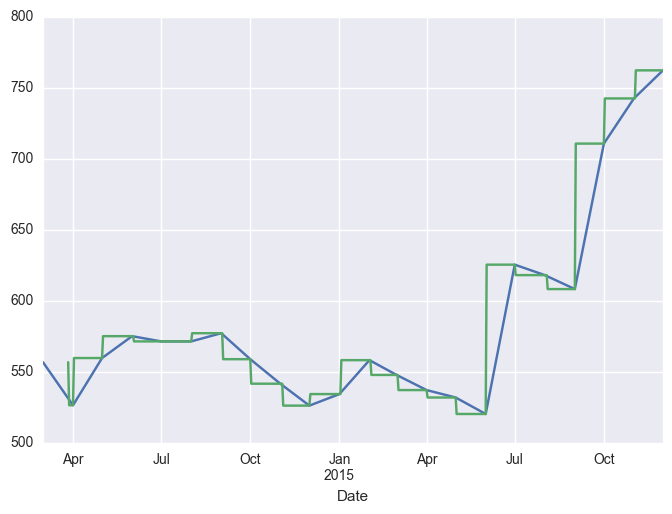

In [15]:
df.Close.resample('M').mean().plot()
df.Close.asfreq('D', method = 'backfill').plot()

We can also use the **date_range** function to create our own customised ranges

In [16]:
# specify start and finish
index = pd.date_range('7/14/2014', '12/7/2014')

# as above but only returning month end values
index = pd.date_range('7/14/2014', '12/7/2014', freq = 'BM')

# count forwards from a start point
index = pd.date_range(start = '7/14/2014', periods = 20)

# or backwards from an end point
index = pd.date_range(end = '12/7/2014', periods = 20)

# we can get quite granular too, right down to the second!
index = pd.date_range('12/7/2014 10:34:23', periods = 20)

There is also the **Period** function

In [17]:
december = pd.Period('2014-12', freq = 'M')
print december.start_time, december.end_time

2014-12-01 00:00:00 2014-12-31 23:59:59.999999999


---

## Moving Averages

### Data Processing and Initial Exploration

I'm going to use Rossmann (a large drug retailer) store data to perform this part of the analysis.

In [18]:
data = pd.read_csv('data/rossmann.csv', low_memory = False)
data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


Rename columns.

In [19]:
data.columns = ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday']
data.head(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [20]:
# check datatypes
data.dtypes

store              int64
day_of_week        int64
date              object
sales              int64
customers          int64
open               int64
promo              int64
state_holiday     object
school_holiday     int64
dtype: object

The date dtype is an object, so set the date column to **datetime** format.

In [21]:
data['date'] = pd.to_datetime(data['date'])

Set the date column as the index.

In [22]:
data.set_index('date', inplace = True)

Sort the index in ascending order.

In [23]:
data.sort_index(ascending = True, inplace = True)

Create a couple of extra columns.

In [24]:
data['year'] = data.index.year
data['month'] = data.index.month

In [25]:
data.head(3)

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,year,month
date,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,2013,1
2013-01-01,379,2,0,0,0,0,a,1,2013,1
2013-01-01,378,2,0,0,0,0,a,1,2013,1


I'm going to start with a subset of three stores.

In [26]:
stores = data.loc[data['store'].isin([1,4,9]), :]

Draw a factorplot to help with visualising the data.

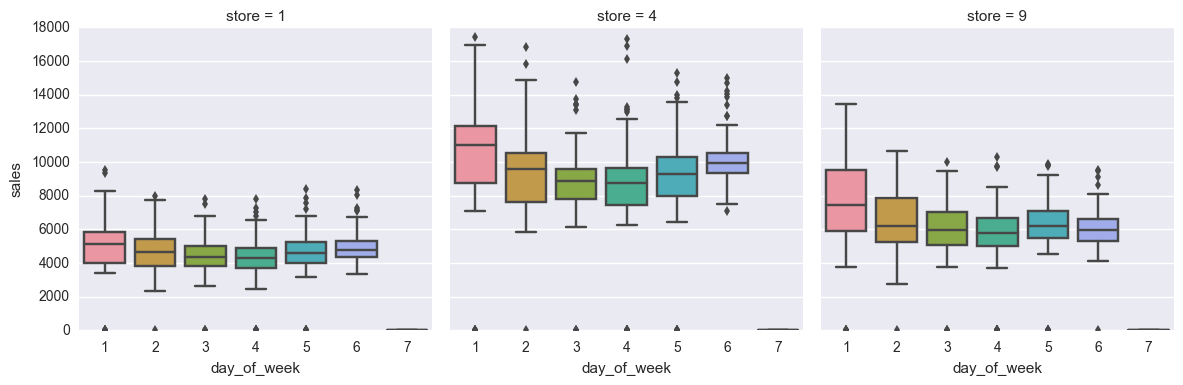

In [27]:
sns.factorplot(data = stores, x = 'day_of_week', y = 'sales', col = 'store', kind = 'box')
plt.show()

Plot the sales for Store 1.

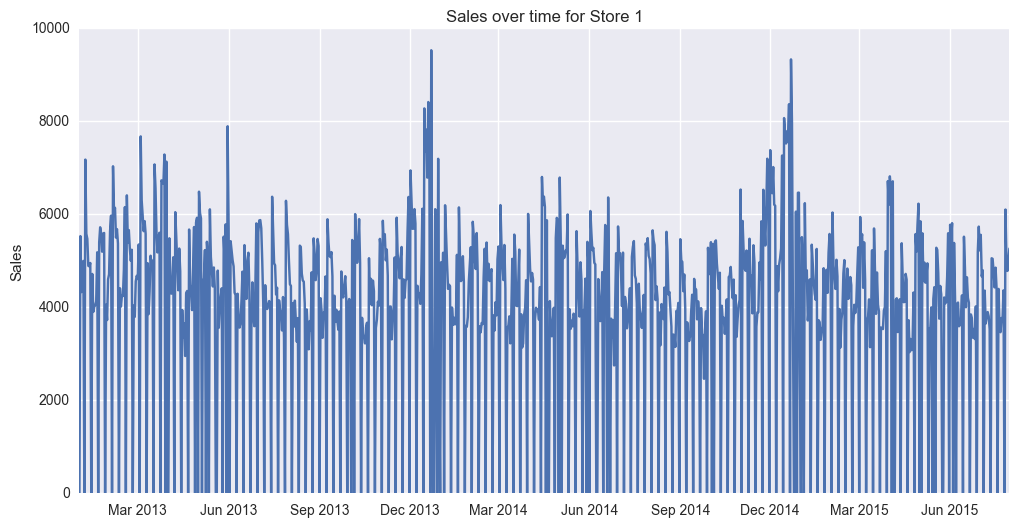

In [28]:
store_1 = stores.loc[stores['store'] == 1, :]
plt.figure(figsize = (12,6))
plt.plot(store_1.index, store_1['sales'])
plt.ylabel('Sales')
plt.title('Sales over time for Store 1')
plt.show()

How does the data look if we only use days when the store was open?

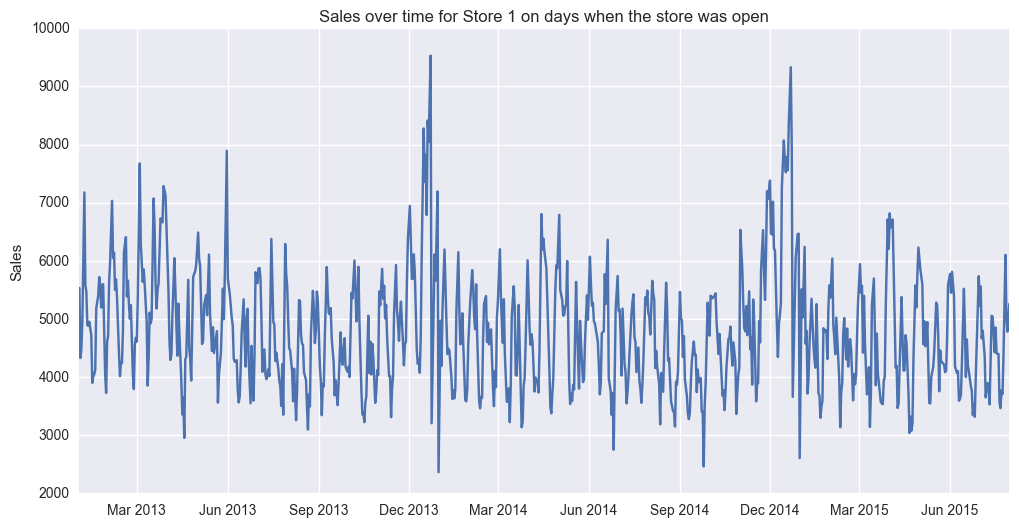

In [29]:
store_1_open = stores.loc[(stores.store == 1) & (stores.open == 1), :]
plt.figure(figsize = (12,6))
plt.plot(store_1_open.index, store_1_open['sales'])
plt.ylabel('Sales')
plt.title('Sales over time for Store 1 on days when the store was open')
plt.show()

### Smoothing using Moving Averages

Create an array object consisting of the index datetimes for the selection.

In [30]:
date_ticks = stores.loc[(stores.store == 1) & (stores.open == 1), :].index.to_pydatetime()

Select the sales and customer data for the selection.

In [31]:
s1_sales = stores.loc[(stores.store == 1) & (stores.open == 1), :]['sales']
s1_cust = stores.loc[(stores.store == 1) & (stores.open == 1), :]['customers']

Use the **rolling** function in Pandas to create a rolling mean. There are a few parameters that can be utilised.
* *window* is the number of days to include in the average
* *center* determines whether the window is centered on the date or uses data prior to that date
* *freq* gives the period to roll the averages up to: D for day, M for month or A for year

In [32]:
# use a window of 7 observations
s1_sales_rollmean = s1_sales.rolling(window = 7).mean()
s1_cust_rollmean = s1_cust.rolling(window = 7).mean()

Standardise the data so they can be plotted on the same scale.

In [33]:
s1_sales_norm = (s1_sales - s1_sales.mean()) / s1_sales.std()
s1_cust_norm = (s1_cust - s1_cust.mean()) / s1_cust.std()

Rolling mean for standardised version of data.

In [34]:
s1_sales_rollmean_norm = s1_sales_norm.rolling(window = 7).mean()
s1_cust_rollmean_norm = s1_cust_norm.rolling(window = 7).mean()

Let's see the effect of this with the smoothed sales data.

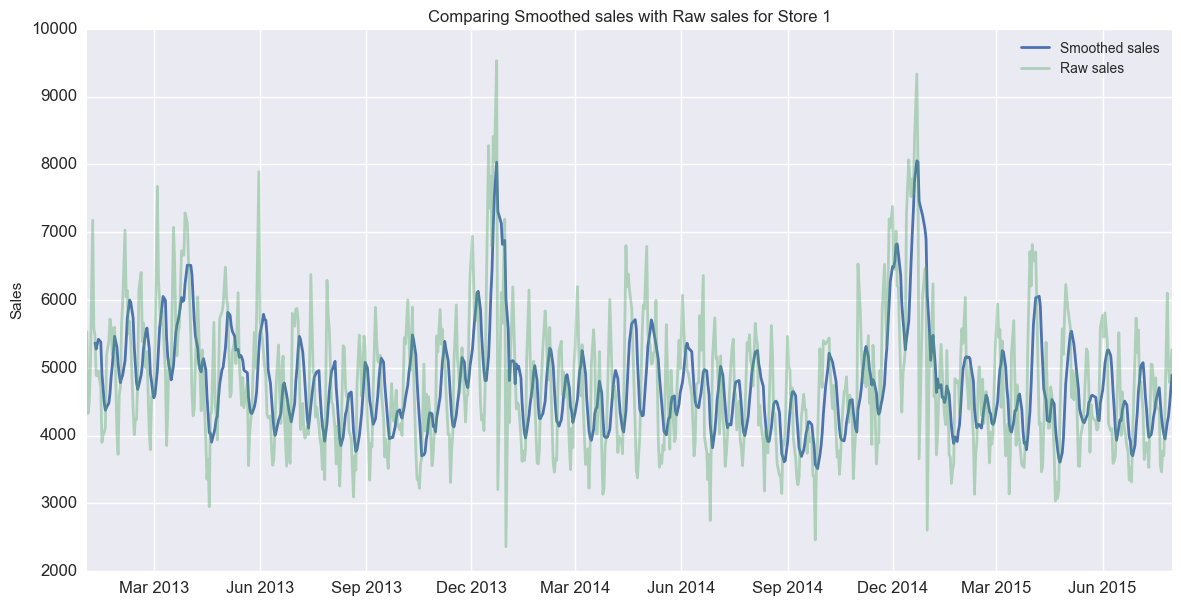

In [35]:
plt.figure(figsize = (14,7))
plt.plot(date_ticks, s1_sales_rollmean, alpha = 1, lw = 2, label = "Smoothed sales")
plt.plot(date_ticks, s1_sales, alpha = 0.4, lw = 2, label = "Raw sales")
plt.ylabel("Sales")
plt.title("Comparing Smoothed sales with Raw sales for Store 1")
plt.legend()
plt.tick_params(labelsize = 12)

Now let's compare the smoothed sales data with the smoothed customer numbers. Given the normalised figures, plotting them on the same scale allows us to see the relationships between the two more clearly.

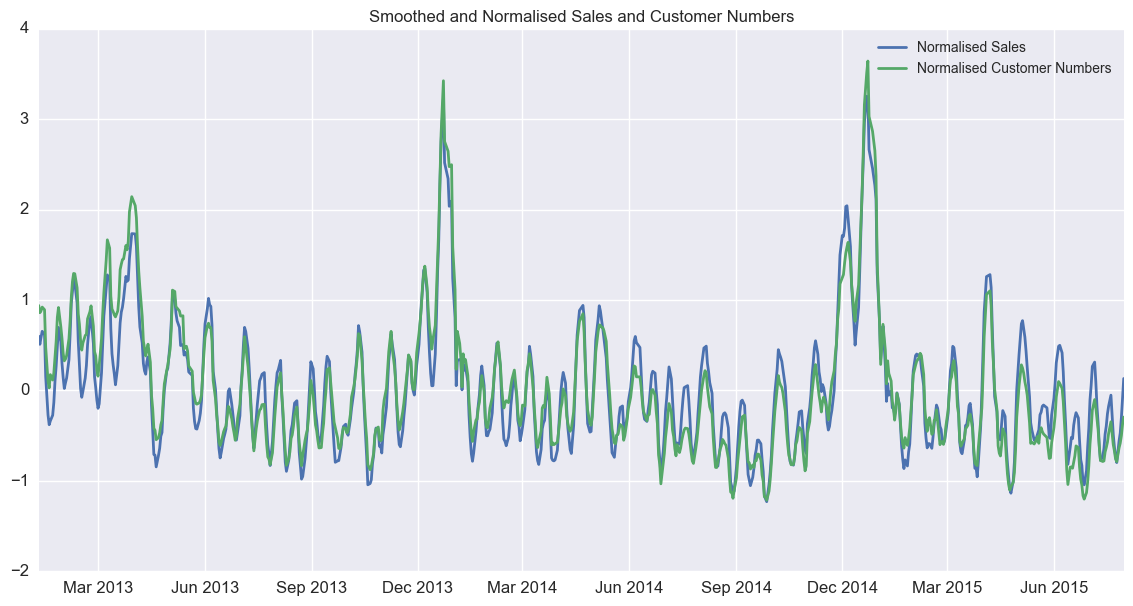

In [36]:
plt.figure(figsize = (14,7))
plt.plot(date_ticks, s1_sales_rollmean_norm, alpha = 1, lw = 2, label = 'Normalised Sales')
plt.plot(date_ticks, s1_cust_rollmean_norm, alpha = 1, lw = 2, label = 'Normalised Customer Numbers')
plt.legend()
plt.tick_params(labelsize = 12)
plt.title('Smoothed and Normalised Sales and Customer Numbers')
plt.show()

Let's continue to investigate the data. Here we look at Store 1 in 2014.

In [37]:
s1_2014 = data.loc[(data.store == 1) & (data.year == 2014), :]
s1_2014.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,year,month
date,,,,,,,,,,
2014-01-01,1,3,0,0,0,0,a,1,2014,1
2014-01-02,1,4,4969,618,1,0,0,1,2014,1
2014-01-03,1,5,4190,552,1,0,0,1,2014,1
2014-01-04,1,6,5173,660,1,0,0,1,2014,1
2014-01-05,1,7,0,0,0,0,0,1,2014,1


Let's calculate the median sales using weekly sampling. This gives us the median daily sales figure during the week *finishing* on the date in the index.

In [38]:
weekly_sales_s1 = s1_2014[['sales']].resample('W').median()
weekly_sales_s1.head()

,sales
date,
2014-01-05,4190
2014-01-12,4486
2014-01-19,3776
2014-01-26,4597
2014-02-02,3789


The rolling function will return the n-day median sales figure.

In [39]:
weekly_sales_s2 = s1_2014[['sales']].rolling(window = 2, center = True).median()
weekly_sales_s2.head()

,sales
date,
2014-01-01,NaN
2014-01-02,2484.5
2014-01-03,4579.5
2014-01-04,4681.5
2014-01-05,2586.5


Now we calculate the weekly rolling median sales for Store 1 in 2014. First we resample across the week and sum the values; then we calculate a rolling window of 2 weeks and get the median.

In [40]:
weekly_store_sales = s1_2014[['sales']].resample('W').sum().rolling(window = 2, center = True).median()
weekly_store_sales.head()

,sales
date,
2014-01-05,NaN
2014-01-12,22166.0
2014-01-19,26977.0
2014-01-26,27028.0
2014-02-02,27910.0


### Expanding Mean

An Expanding Mean simply uses all the datapoints up to the current time to calculate the mean, as opposed to a moving window. Let's plot the rolling mean and the expanded mean for Store 1 sales in 2014.

In [41]:
# this will help with deprecation warnings
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [42]:
date_ticks = s1_2014.resample('W').index.to_pydatetime()

rolling_mean = s1_2014[['sales']].resample('W').sum().rolling(window = 2, center = True).mean()

# in this case we resample also to a weekly sum, but now we take an expanding mean
expanding_mean = s1_2014[['sales']].resample('W').sum().expanding().mean()
expanding_mean.head()

,sales
date,
2014-01-05,14332.0
2014-01-12,22166.0
2014-01-19,22762.0
2014-01-26,24597.0
2014-02-02,24821.2


Let's plot these for comparison - the rolling mean is taking only the surrounding two weeks as input but the expanding mean carries on and takes all past values into account.

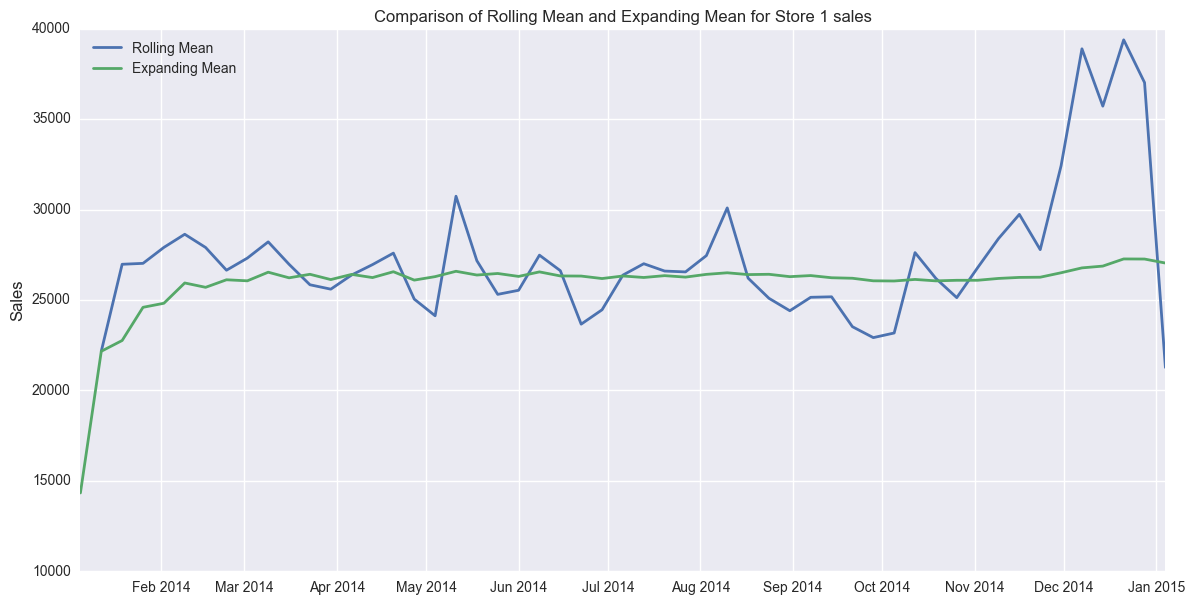

In [43]:
plt.figure(figsize = (14,7))
plt.plot(date_ticks, rolling_mean, alpha = 1, lw = 2, label = 'Rolling Mean')
plt.plot(date_ticks, expanding_mean, alpha = 1, lw = 2, label = 'Expanding Mean')
plt.legend(loc = 'upper left')
plt.ylabel("Sales", fontsize = 12)
plt.title("Comparison of Rolling Mean and Expanding Mean for Store 1 sales")
plt.tick_params(labelsize = 10)

### Exponentially Weighted Average

The problem with an expanding mean is that it gives equal weighting to all points in the past, which is not particularly desirable. We can address this by using an exponentially weighted mean which places greater emphasis on recent datapoints.

In [44]:
# here I will take the Store 1 data from the winter of 2014
s1_winter_14 = s1_2014.loc[(s1_2014.month > 9), :]

# the rolling mean is as we saw before
rolling_mean = s1_winter_14['sales'].rolling(window = 5, center = True).mean()

# again, the expanding mean is as we saw before
expanding_mean = s1_winter_14['sales'].expanding().mean()

Now for the exponentially weighted mean. The span argument below defines the strength of decay, such that a higher span means a slower decay (which would more closely resemble an expanding mean). Note that ewm stands for exponentially weighted method.

In [45]:
exp_weighted_mean = s1_winter_14['sales'].ewm(span = 10).mean()

Now plot the data

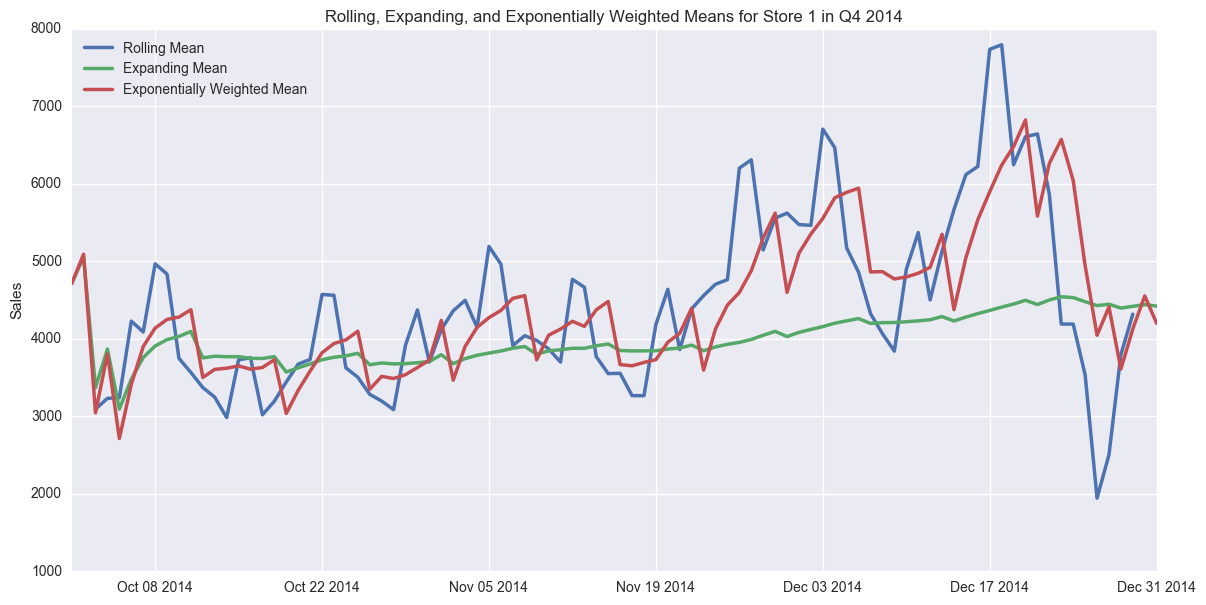

In [46]:
plt.figure(figsize = (14,7))
plt.plot(rolling_mean.index, rolling_mean, lw = 2.5, label = 'Rolling Mean')
plt.plot(expanding_mean.index, expanding_mean, lw = 2.5, label = 'Expanding Mean')
plt.plot(exp_weighted_mean.index, exp_weighted_mean, lw = 2.5, label = 'Exponentially Weighted Mean')
plt.legend(loc = 'upper left')
plt.ylabel('Sales')
plt.title("Rolling, Expanding, and Exponentially Weighted Means for Store 1 in Q4 2014")
plt.show()

## Trendlines

In [47]:
# take a selection of the data (where the data is rising)
increasing_section = rolling_mean[datetime(2014,12,6):datetime(2014,12,17)]

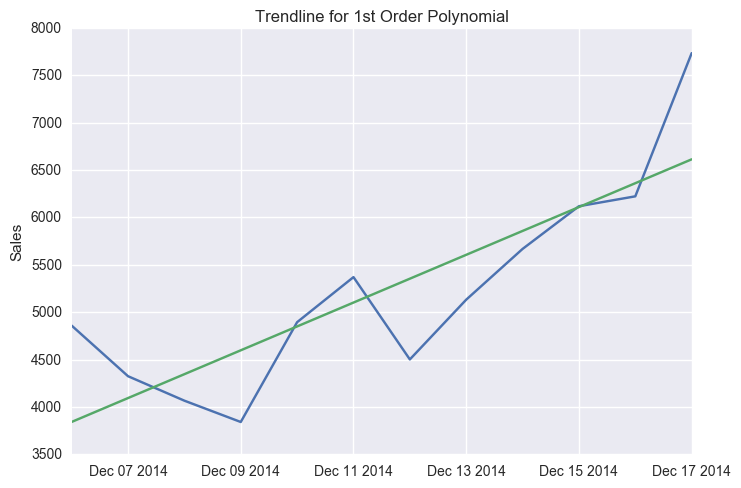

Trendline parameters
 
252 x + 3842


In [48]:
# fit a one dimensional linear regression to this data
line_coef = np.polyfit(range(0, len(increasing_section)), increasing_section, 1)
polynomial = np.poly1d(line_coef)

# plot the linear regression along with the data
plt.plot(increasing_section.index, increasing_section, label = 'Data')
plt.plot(increasing_section.index, polynomial(range(0, len(increasing_section))), label = '1st Order Trendline')
plt.ylabel('Sales')
plt.title('Trendline for 1st Order Polynomial')
plt.show()

# view the function fitted
print 'Trendline parameters'
print polynomial

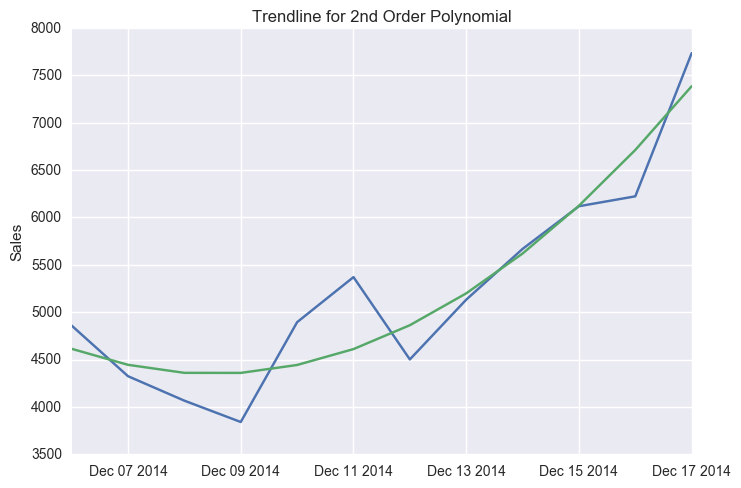

Trendline parameters
      2
42.1 x - 211 x + 4613


In [49]:
# fit a two dimensional linear regression to this data
line_coef_2 = np.polyfit(range(0, len(increasing_section)), increasing_section, 2)
polynomial_2 = np.poly1d(line_coef_2)

# plot the linear regression along with the data
plt.plot(increasing_section.index, increasing_section, label = 'Data')
plt.plot(increasing_section.index, polynomial_2(range(0, len(increasing_section))), label = '2nd Order Trendline')
plt.ylabel('Sales')
plt.title('Trendline for 2nd Order Polynomial')
plt.show()

# view the function fitted
print 'Trendline parameters'
print polynomial_2

## Autocorrelation

In non-time series analysis, when we investigate relationships we take correlations between variables. For example, we may choose to calculate the correlation between height and weight. In time series analysis we are interested in how a variable is correleated with *itself*, or rather, at different points in time. This is known as autocorrelation and allows us to find trends or patterns in the data.

To compute autocorrelation, we specify a lag between the current point and the prior point used to calculate the correlation. So, a lag of seven for daily data would compute the correlation of a particular day with the same day from the previous week. I'll start by computing the autocorrelation for Store 1 sales data on a 1 and 7 day lag.

In [50]:
s1 = data.loc[(data['store'] == 1), :]

autocorr_day_lag1 = s1['sales'].autocorr(lag = 1)
autocorr_week_lag1 = s1['sales'].resample('W').sum().autocorr(lag = 1)

# autocorrelation of each day with the previous day
print autocorr_day_lag1.round(3)

# autocorrelation of each week with the previous week
print autocorr_week_lag1.round(3)

-0.127
-0.159


We see small negative correlations. Let's try to calculate the daily autocorrelation with a lag of 7.

In [51]:
autocorr_day_lag7 = s1['sales'].autocorr(lag = 7)
print autocorr_day_lag7.round(3)

0.631


There is clearly a weekly trend. Now we calculate the autocorrelation for Store 1 through a whole week.

In [52]:
s1_autocorrelations = [s1['sales'].autocorr(lag = l) for l in range(1,8)]
s1_autocorrelations

[-0.12732514339140216,
 -0.034787155707946951,
 0.06473611291299991,
 -0.0018114479109864311,
 -0.109457935288973,
 -0.22963935576549277,
 0.63071924328402873]

Calculate and plot a range of autocorrelation lags for 1-31 days.

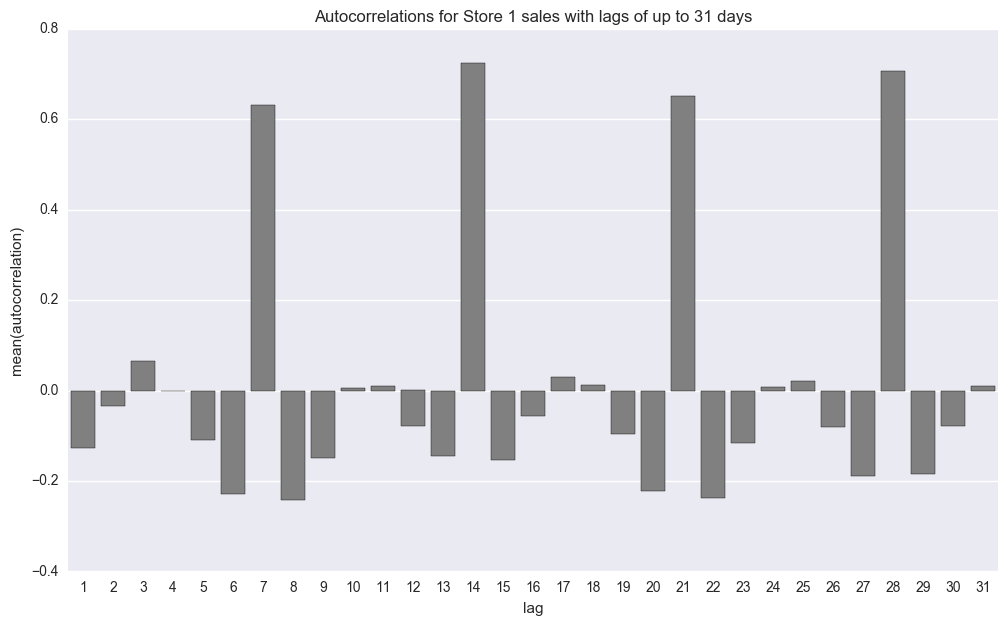

In [53]:
s1_monthly_autocorrelations = [s1.sales.autocorr(lag = l) for l in range(1,32)]
s1_autocorr = pd.DataFrame({'lag': range(1,32), 'autocorrelation': s1_monthly_autocorrelations})
plt.figure(figsize = (12,7))
sns.barplot(x = s1_autocorr.lag, y = s1_autocorr.autocorrelation, color = 'grey')
plt.title('Autocorrelations for Store 1 sales with lags of up to 31 days')
plt.show()

Finally, some alternative plotting using Stats Models.

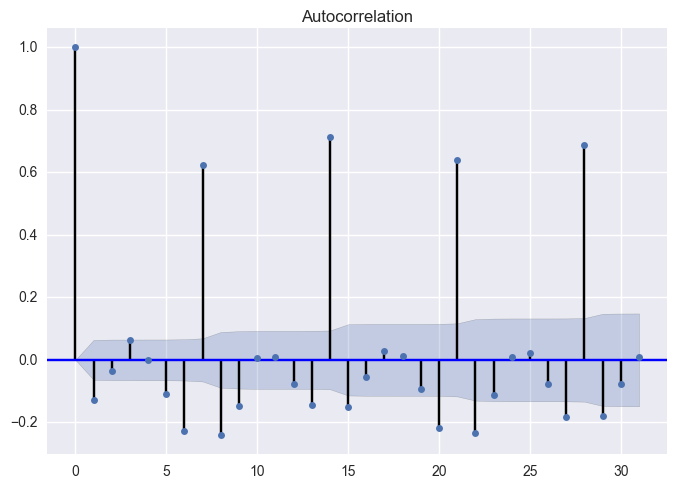

In [54]:
plot_acf(s1.sales.values, lags = 31)
plt.show()

We can obtain the values as follows.

In [55]:
acf(s1.sales, nlags = 31)

array([ 1.        , -0.12703786, -0.03469319,  0.06454937, -0.00180766,
       -0.10904274, -0.22783504,  0.6248786 , -0.2401515 , -0.14869745,
        0.00624578,  0.01006485, -0.07707318, -0.14363042,  0.71435429,
       -0.15188393, -0.05551585,  0.02901103,  0.01113764, -0.09400308,
       -0.21875595,  0.63865175, -0.23360339, -0.11384778,  0.00788378,
        0.02095157, -0.07841381, -0.18374454,  0.68804836, -0.17930762,
       -0.07734379,  0.01060628])

---

In this notebook we started with some basic Datetime functionality which is very useful when manipulating dataframes with time series data.

Then we looked at smoothing using moving averages, expanding means and exponentially weighted averages.

Finally we saw how to calculate trendlines before finishing off with computing autocorrelations with differing lags.